# Extract the spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 18th 2017
- update : January 24th 2017


- The goal is to extract the spectrum after the rotation.


-1) First the 1 orders are extracted. One must check the rotation is correct

-2) Check the 2 orders are well aligned along X by looking at the transverse profile : if you see two peaks this means the rotation is bad.

-3) For this the central star light must having been turned off.

In [83]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [84]:
print theNotebook

Extract_Spectrum_HEN2_5


In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [86]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [87]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [88]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [89]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [90]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [91]:
from IPython.display import Image, display

In [92]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [93]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [94]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [95]:
def subplots_adjust(*args, **kwargs):
    """
    call signature::

      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)

    Tune the subplot layout via the
    :class:`matplotlib.figure.SubplotParams` mechanism.  The parameter
    meanings (and suggested defaults) are::

      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for blank space between subplots
      hspace = 0.2   # the amount of height reserved for white space between subplots

    The actual defaults are controlled by the rc file
    """
    fig = gcf()
    fig.subplots_adjust(*args, **kwargs)
    draw_if_interactive()

### Output directory for images generated in the notebook view (not true fits images)

In [96]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [97]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [98]:
inputdir="./cut_fitsimages"
object_name='HEN2_5'

### output fits file

In [99]:
outputdir="./spectrum_fitsspec"

In [100]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [101]:
input_filelist=os.listdir(inputdir) 

In [102]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [103]:
input_filelist[:5]

array(['cutimg_HEN2_5_20170117_197.fits',
       'cutimg_HEN2_5_20170117_198.fits',
       'cutimg_HEN2_5_20170117_199.fits',
       'cutimg_HEN2_5_20170117_200.fits', 'cutimg_HEN2_5_20170117_201.fits'], 
      dtype='|S31')

In [104]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [105]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^cutimg_HEN2_5_20170117_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages
    
    
    

In [106]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [107]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [108]:
print indexes_files

[197 198 199 200 201 202 203 204 205 206 207]


In [109]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [110]:
sorted_numbers=indexes_files[sorted_indexes]

In [111]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10]


In [112]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [113]:
#sorted_files

## Build full filename
----------------------------

In [114]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [115]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [116]:
print sorted_filenames.shape

(11,)


## Acces to data of  images
----------------------------------

In [117]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [118]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo

In [119]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [120]:
len(all_images)

11

In [121]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    It returns the x0, where the maximum occurs in the image
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=1000)
        axarr[iy,ix].set_title(all_titles[index])
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'intput_images.pdf')
    plt.savefig(figfilename)  
    
    return thex0

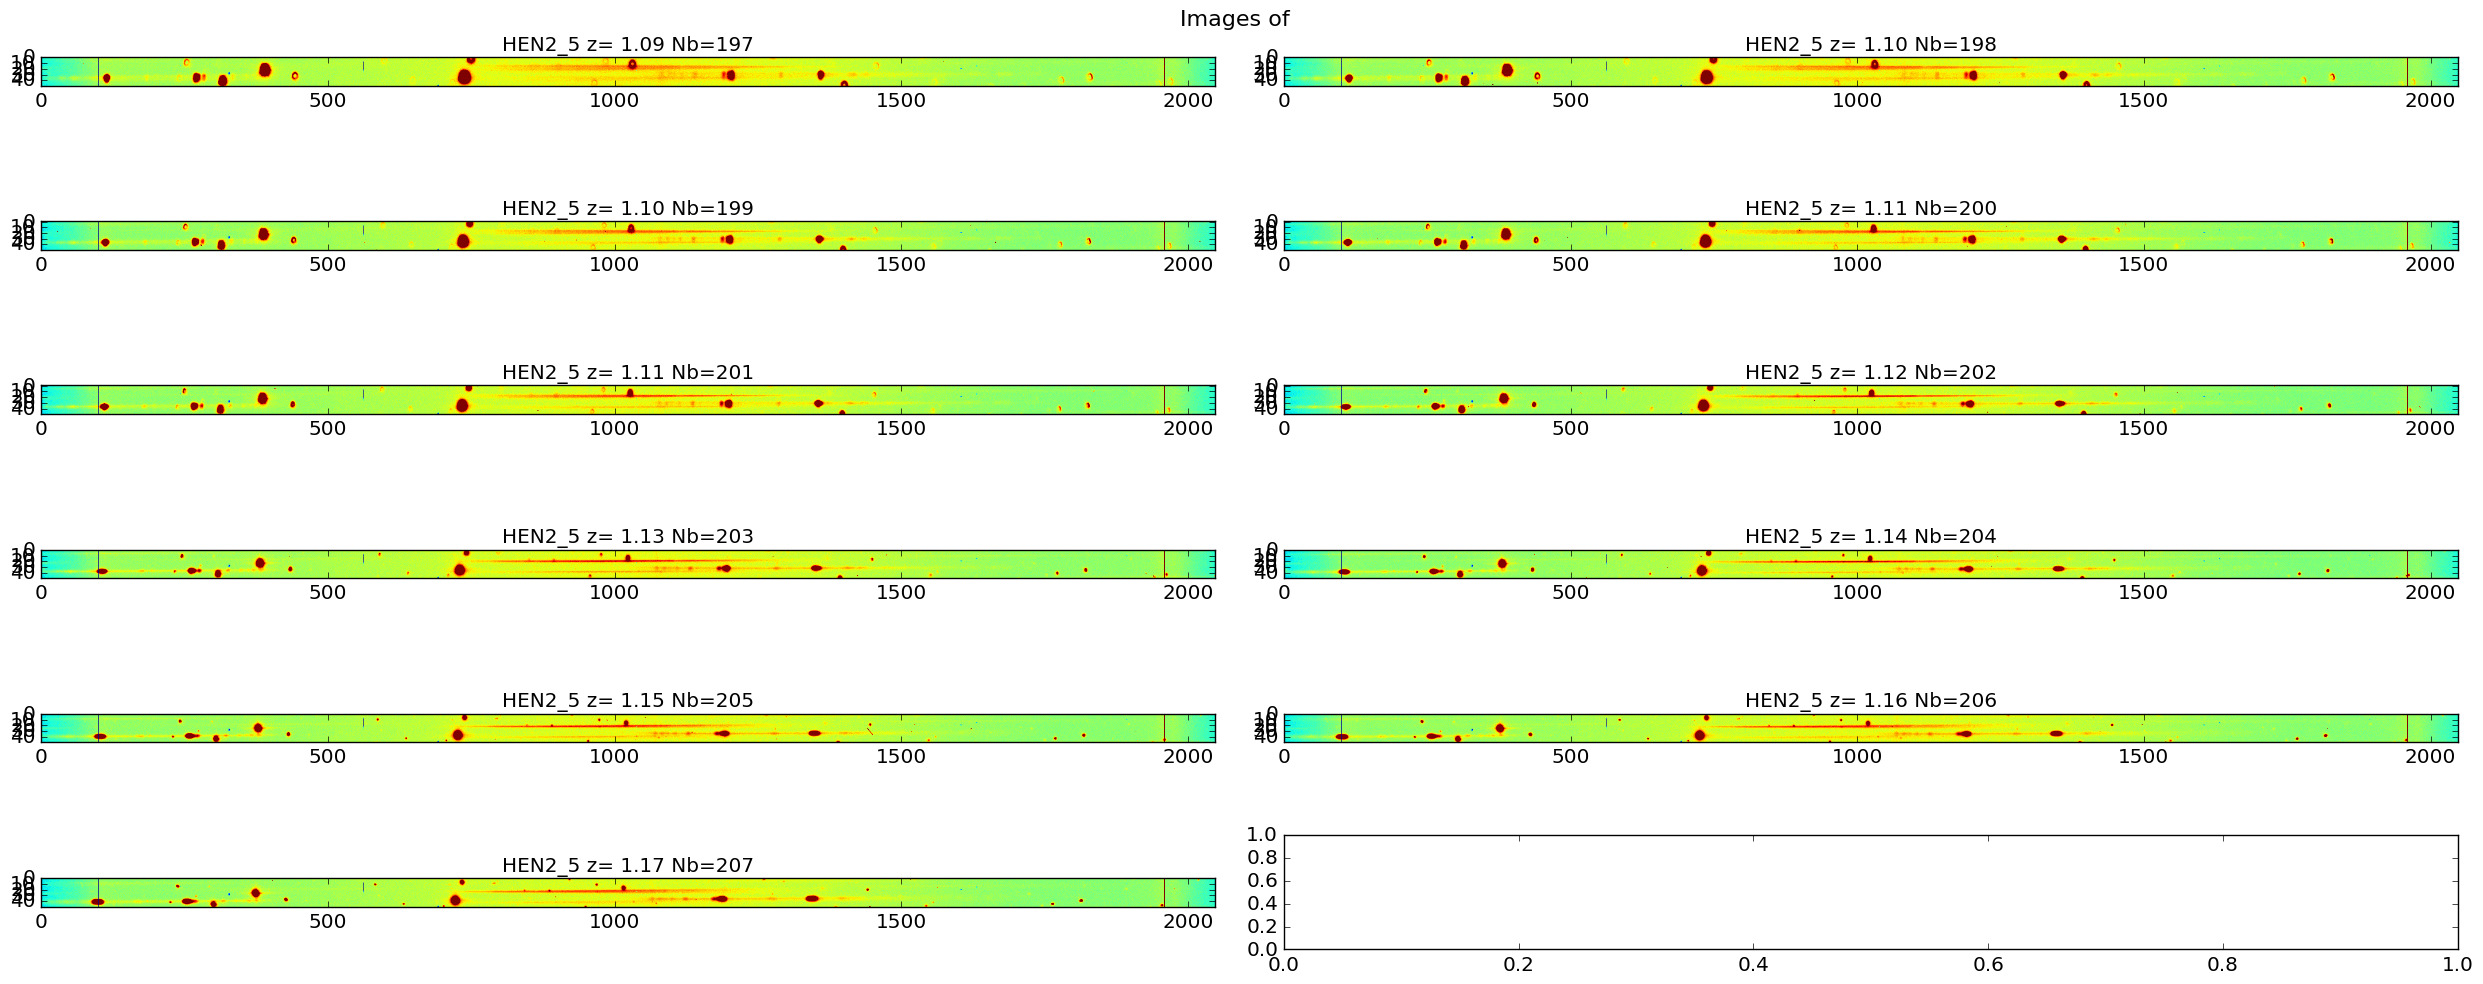

In [122]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

In [156]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowProfiles(all_images,all_titles,object_name,all_expo,dir_top_images,figname):
    """
    ShowSlices: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/2)+1
    all_spectra = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        
  
        
        ix=index%2
        iy=index/2
        full_image=np.copy(all_images[index])
        
        
        reduc_image=full_image/all_expo[index] 
        spectrum=np.sum(full_image,axis=0)
        all_spectra.append(spectrum)
                
       
        axarr[iy,ix].plot(spectrum,'r-',lw=3); axarr[iy,ix].grid(True); 
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0,300000.)
        #axarr[iy,ix].set_xlim(0,1800.)
    
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename) 
    return all_spectra

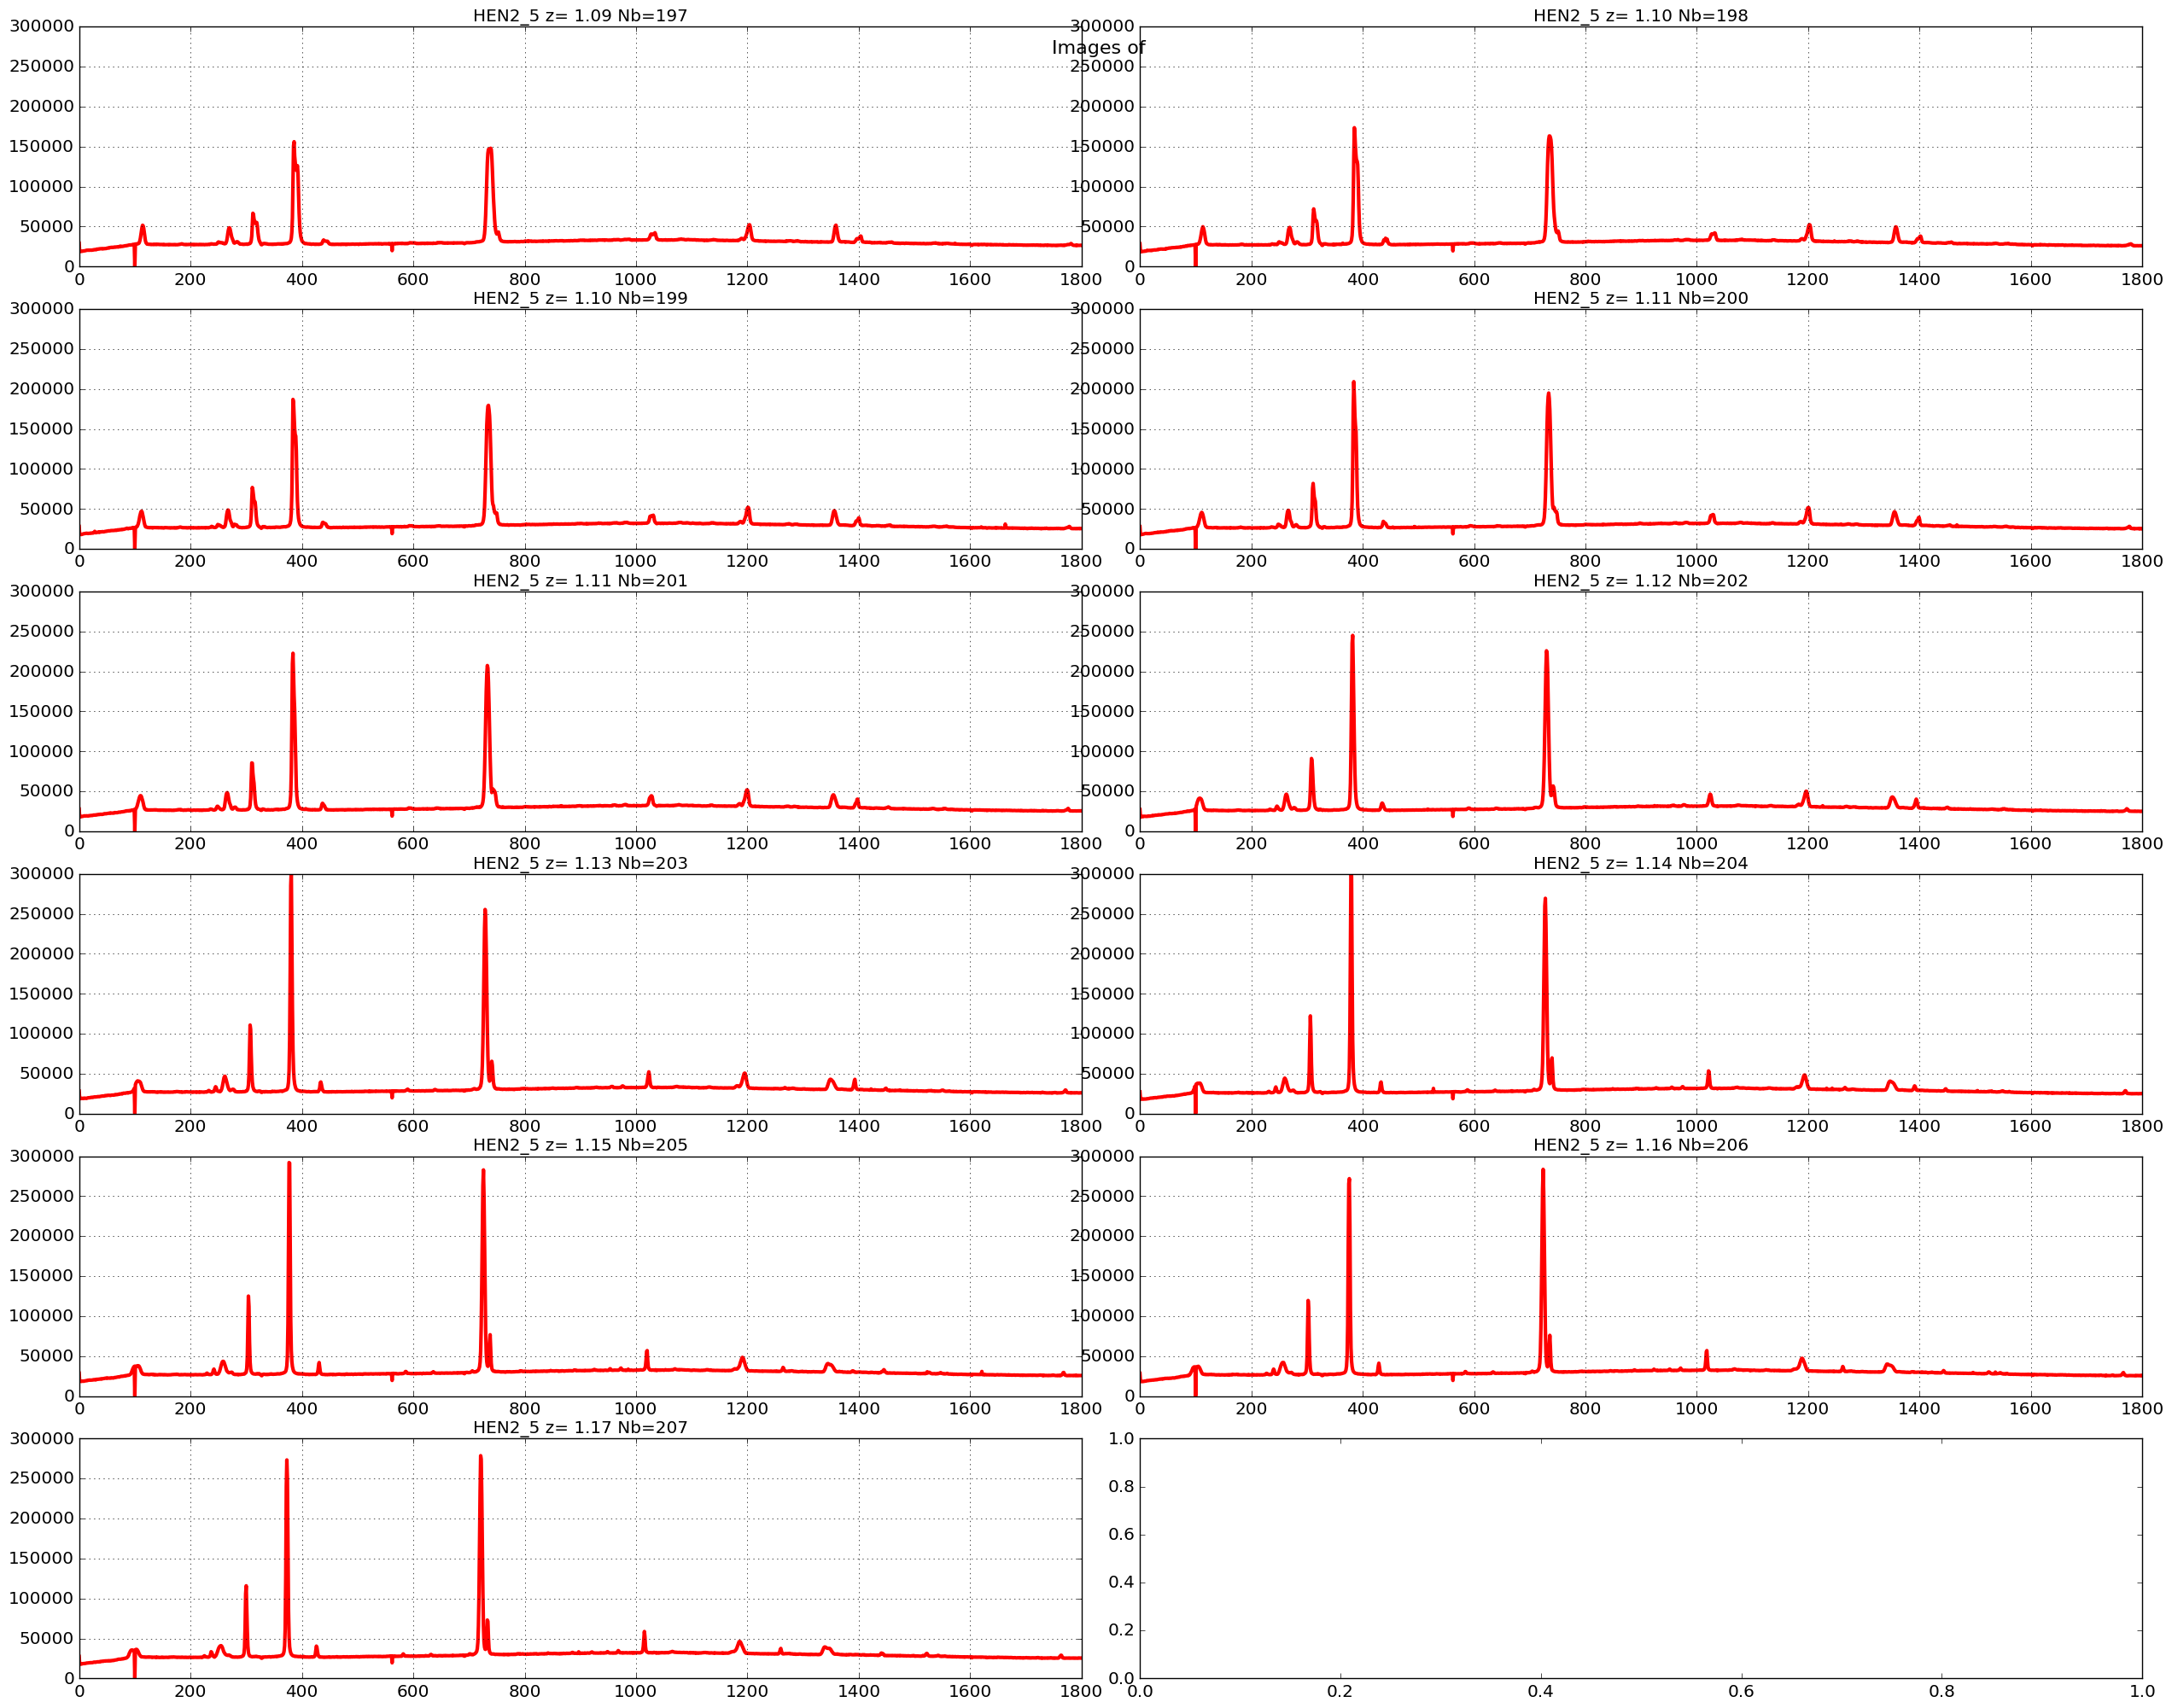

In [154]:
all_spectra=ShowProfiles(all_images,all_titles,object_name,all_expo,dir_top_images,'all_spectra.pdf')

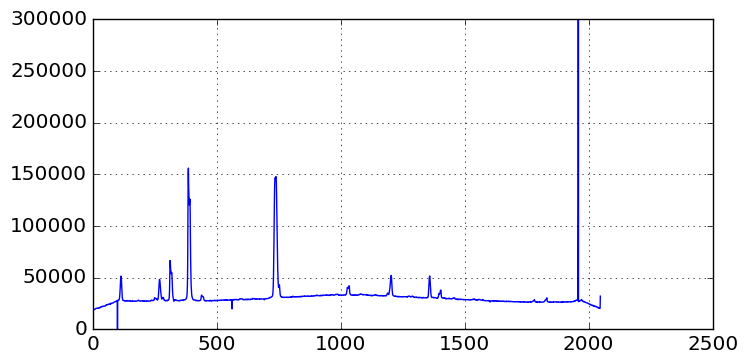

In [173]:
plt.figure(figsize=(8,4))
plt.plot(all_spectra[0])
plt.ylim(0,300000.)
plt.grid(True)

Table des intensités des raies de Hen2-5
notes (n): p=trop faible pour être mesuré; S = saturé. Qual = B, ça veut dire qualité moyenne je pense...
Normalisé à I(Hbeta=4861)=100.0
Avec log(Fbeta en mW/m2) = -11.29 +/- 0.03
Reference: Spectrophotometric observations of planetary nebulae  high above the Galactic plane. Cuisinier F., Acker A., Koeppen J.      <Astron. Astrophys. 307, 215 (1996)>

264.4-12.7
Ident   He 2-5
Qual    B

4102    20.7
4340    39.6
4363    2.7
4388    0.3
4472 n  4.6
4861    100.0
4922 n  1.3
4959 n  193.9
5007    605.0
5518 n  0.3
5538 n  0.5
5754    0.7
5876    17.4
6548 n  p
6563 n  S
6584 n  47.5
6678    5.2
6716 n  1.0
6731 n  1.9
7065    8.9
7136    13.3
7325    11.0

In [158]:
X=[4102, 4340, 4363, 4388,4472, 4861, 4922, 4959, 5007, 5518,5538, 5754,5876, 6548, 6563,6584, 6678, 6716,6731,7065,7136,7325]
Y=[20.7, 39.6, 2.7, 0.3, 4.6, 100.,1.3, 193.9, 605.0, 0.3, 0.5,0.7,17.4,0.,0., 47.5,5.2,1.,1.9,8.9,13.3,11.]

In [159]:
len(X)

22

In [160]:
len(Y)

22

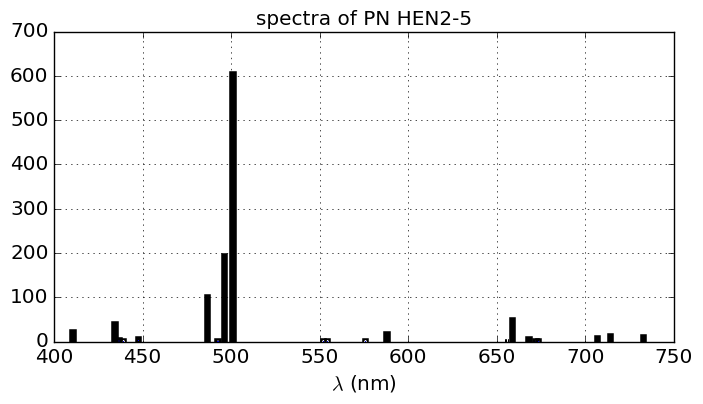

In [177]:
WL=np.array(X)/10.
plt.figure(figsize=(8,4))
plt.grid()
plt.bar(WL,Y,lw=4)
plt.xlabel('$\lambda$ (nm)')
plt.title('spectra of PN HEN2-5')

### prepare outputfilename

In [125]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [126]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_HEN2_5_20170117_197.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_198.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_199.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_200.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_201.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_202.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_203.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_204.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_205.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_206.fits',
 './spectrum_fitsspec/finalSpectra_HEN2_5_20170117_207.fits']

### Save outputfilename

In [127]:
#for idx,file in np.ndenumerate(newfullfilenames):
#    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=spectra_right[idx[0]])
#    thdulist = fits.HDUList(prihdu)
#    thdulist.writeto(file,clobber=True)

In [128]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='Spectrum',format='E',array=all_spectra[idx[0]])
    cols=fits.ColDefs([col1])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)

TypeError: 'NoneType' object has no attribute '__getitem__'